# Learning PyTorch: What is `torch.nn` really?

Source: https://pytorch.org/tutorials/beginner/nn_tutorial.html

(*by Jeremy Howard, fast.ai. Thanks to Rachel Thomas and Francisco Ingham*)

PyTorch provides the elegantly designed modules and classes `torch.nn` , `torch.optim` , `Dataset` , and `DataLoader` to help us create and train neural networks. The aim here is to really understand exactly what they’re doing.

We will first train basic neural net on the MNIST data set without using any features from these models. Then, we will incrementally add one feature from `torch.nn`, `torch.optim`, `Dataset`, or `DataLoader` at a time, showing exactly what each piece does, and how it works to make the code either more concise, or more flexible.

# MNIST data setup

We will use the classic MNIST dataset, which consists of black-and-white images of hand-drawn digits (between 0 and 9).

This dataset is in numpy array format, and has been stored using pickle, a python-specific format for serializing data.

Each image is 28 x 28, and is being stored as a flattened row of length 784 (=28x28).

In [1]:
from pathlib import Path
import requests           # to download the dataset

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

Shape of x_train: (50000, 784)


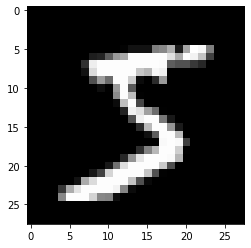

In [3]:
from matplotlib import pyplot
import numpy as np

# Let's take a look at one of the image.
# We need to reshape it to 2d first.

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print("Shape of x_train:", x_train.shape)

In [4]:
# Let's take a look at the data representing the above image.
x_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [5]:
# PyTorch uses torch.tensor, rather than numpy arrays, so we need to convert our data.

import torch

x_train, y_train, x_valid, y_valid = map(torch.tensor, 
                                         (x_train, y_train, x_valid, y_valid)
                                         )

n, c = x_train.shape                # n=total records (50000), c=784

print("== x_train ==")
print(x_train)
print(x_train.shape)

print("\n== y_train ==")
print(y_train)
print(y_train.shape)
print(y_train.min(), y_train.max()) # target contains values from 0 to 9

== x_train ==
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([50000, 784])

== y_train ==
tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000])
tensor(0) tensor(9)


# 1. Neural net from scratch (no torch.nn)

We will create and train a minimal neural network (in this case, a logistic regression, since we have no hidden layers) entirely from scratch.

For this simple linear model, we will create random tensors for weights and zero-filled tensors for bias.

We tell PyTorch that they require a gradient. This causes PyTorch to record all of the operations done on the tensor, so that it can calculate the gradient during back-propagation automatically!

We are initializing the weights here with [Xavier initialisation](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) (by multiplying with `1/sqrt(n)`).

For the weights, we set `requires_grad` after the initialization, since we don’t want that step included in the gradient. (Note that a trailing `_` in PyTorch signifies that the operation is performed in-place.)

In [6]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [7]:
weights  # Take a look at the weights

tensor([[-0.0281, -0.0047,  0.0365,  ..., -0.0185,  0.0296, -0.0136],
        [-0.0302,  0.0453, -0.0247,  ..., -0.0172,  0.0381, -0.0511],
        [ 0.0258, -0.0097,  0.0454,  ...,  0.0005,  0.0536,  0.1089],
        ...,
        [-0.0355,  0.0197, -0.0262,  ...,  0.0171, -0.0237,  0.0482],
        [ 0.0014,  0.0013, -0.0051,  ..., -0.0300, -0.0360, -0.0413],
        [-0.0104,  0.0562,  0.0538,  ...,  0.0528, -0.0199, -0.0098]],
       requires_grad=True)

In [8]:
bias   # Take a look at the bias

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

### Model and Activation Function

Thanks to PyTorch’s ability to calculate gradients automatically, we can use any standard Python function (or callable object) as a model! 

So let’s just write a plain matrix multiplication and broadcasted addition to create a simple linear model. We also need an activation function, so we’ll write `log_softmax` and use it. PyTorch will even create fast GPU or vectorized CPU code for your function automatically.

Note: 

The [discussion here](
https://discuss.pytorch.org/t/what-is-the-difference-between-log-softmax-and-softmax/11801) mentioned that `log_softmax` essentially does `log(softmax(x))`, but the practical implementation is different and more efficient while doing the same operation.

And the answer provided [here](https://datascience.stackexchange.com/questions/40714/what-is-the-advantage-of-using-log-softmax-instead-of-softmax) explains the formula used in the function below.

We can also read [here](https://zhang-yang.medium.com/understanding-cross-entropy-implementation-in-pytorch-softmax-log-softmax-nll-cross-entropy-416a2b200e34) on how Pytorch’s Cross Entropy function relates to softmax, log softmax, and NLL.

In [9]:
def log_softmax(x):
    # Seems like this is returning the log likelihood?
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias) 

In [10]:
# We will call our function on one batch of data (in this case, 64 images). 
# This is one forward pass. 

bs = 64             # batch size

xb = x_train[0:bs]  # a mini-batch from x, with shape [64, 784]
preds = model(xb)   # predictions from 1 batch of data

# Print values of the first 5 predictions in the batch
for i in range(5):
    print("preds[%d]:" %i, preds[i])        
print("\nShape of preds:", preds.shape)

preds[0]: tensor([-2.5770, -2.3581, -2.4281, -2.8149, -1.7359, -2.3735, -2.1032, -2.5785,
        -2.0805, -2.4185], grad_fn=<SelectBackward>)
preds[1]: tensor([-2.5676, -2.5730, -2.7850, -2.8245, -2.2423, -2.0983, -1.4850, -2.6982,
        -2.3245, -2.2504], grad_fn=<SelectBackward>)
preds[2]: tensor([-1.8988, -2.8607, -2.3521, -2.6710, -2.5738, -2.0666, -2.5532, -2.2485,
        -2.0314, -2.1959], grad_fn=<SelectBackward>)
preds[3]: tensor([-2.2147, -2.2699, -2.2328, -2.8628, -2.2602, -2.6489, -1.7395, -2.8289,
        -2.1399, -2.3462], grad_fn=<SelectBackward>)
preds[4]: tensor([-1.5505, -2.7288, -2.8154, -3.3499, -2.0239, -2.5469, -1.8582, -2.4600,
        -2.5191, -2.3518], grad_fn=<SelectBackward>)

Shape of preds: torch.Size([64, 10])


In [11]:
# Let's take a look at (xb @ weights + bias), i.e. the data passed into log_softmax().

# shape of xb     : [64, 784]
# shape of weights: [784, 10]
# shape of bias   : [10]
    
(xb @ weights + bias) # shape is [64, 10]

tensor([[-1.8335e-01,  3.5551e-02, -3.4449e-02, -4.2131e-01,  6.5773e-01,
          2.0164e-02,  2.9042e-01, -1.8486e-01,  3.1317e-01, -2.4823e-02],
        [-3.5540e-02, -4.0974e-02, -2.5302e-01, -2.9251e-01,  2.8976e-01,
          4.3371e-01,  1.0470e+00, -1.6615e-01,  2.0756e-01,  2.8165e-01],
        [ 5.4016e-01, -4.2169e-01,  8.6883e-02, -2.3198e-01, -1.3482e-01,
          3.7242e-01, -1.1419e-01,  1.9047e-01,  4.0756e-01,  2.4309e-01],
        [ 9.4622e-02,  3.9392e-02,  7.6493e-02, -5.5348e-01,  4.9136e-02,
         -3.3965e-01,  5.6979e-01, -5.1965e-01,  1.6942e-01, -3.6889e-02],
        [ 9.2329e-01, -2.5501e-01, -3.4165e-01, -8.7608e-01,  4.4992e-01,
         -7.3117e-02,  6.1553e-01,  1.3807e-02, -4.5347e-02,  1.2200e-01],
        [ 3.4730e-01, -3.9007e-01, -1.6095e-01, -5.2212e-01,  3.4346e-01,
          1.9819e-02,  5.6218e-01, -4.3901e-01,  6.3256e-02,  1.0479e-02],
        [-2.0256e-02, -6.7246e-02, -2.6784e-01, -8.3665e-02,  4.5763e-01,
         -2.5513e-01,  4.2428e-0

### Loss Function

Let’s implement [negative log-likelihood](https://medium.com/deeplearningmadeeasy/negative-log-likelihood-6bd79b55d8b6) to use as the loss function.

In [12]:
def nll(preds, targets):
    return -preds[range(targets.shape[0]), targets].mean()
    
loss_func = nll

In [13]:
yb = y_train[0:bs]  # yb is the targets on a batch.
print(yb)           # yb contains 64 digits (value from 0 to 9).
print("\nShape of yb:" , yb.shape)

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])

Shape of yb: torch.Size([64])


In [14]:
# Calling the loss function to calculate loss of the batch.

print("Loss:", loss_func(preds, yb))

Loss: tensor(2.4044, grad_fn=<NegBackward>)


In [15]:
# Cross checking that the loss function is returning values based on the following:

print(-preds[range(64), yb])
print("\nLoss:", -preds[range(64), yb].mean())

tensor([2.3735, 2.5676, 2.5738, 2.2699, 2.3518, 2.5068, 2.4379, 2.9445, 2.4495,
        1.9445, 2.8817, 2.4378, 2.5346, 2.0181, 2.5390, 2.9147, 2.4197, 2.4624,
        2.2163, 2.5343, 2.3859, 2.2502, 2.2181, 2.2489, 2.6323, 2.3776, 2.0961,
        2.9342, 2.5894, 2.6417, 2.6381, 2.4619, 2.5330, 2.5111, 2.3679, 2.5385,
        2.2746, 2.1376, 2.3543, 2.3365, 2.3909, 2.4972, 2.3289, 2.1807, 2.6662,
        2.1280, 2.3718, 2.3478, 2.3422, 3.1763, 2.4071, 2.3157, 2.2498, 2.2387,
        2.1295, 2.6759, 1.9556, 2.2247, 2.1898, 2.1992, 2.3438, 2.1877, 2.2954,
        2.1327], grad_fn=<NegBackward>)

Loss: tensor(2.4044, grad_fn=<NegBackward>)


### Function to calculate accuracy

Let’s also implement a function to calculate the accuracy of our model. For each prediction, if the index with the largest value matches the target value, then the prediction was correct.

In [16]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [17]:
# Let's check the accuracy of our random model.
# We do not expect good result since we have not done any training yet.

print("Accuracy:", accuracy(preds, yb))

Accuracy: tensor(0.0312)


### Training Loop

We can now run a training loop. For each iteration, we will:

- select a mini-batch of data (of size `bs`)
- use the model to make predictions
- calculate the loss
- `loss.backward()` updates the gradients of the model, in this case, weights and bias.

We now use these gradients to update the weights and bias. We do this within the `torch.no_grad()` context manager, because we do not want these actions to be recorded for our next calculation of the gradient. You can read more about how PyTorch’s [Autograd](https://pytorch.org/docs/stable/notes/autograd.html) records operations here.

We then set the gradients to zero, so that we are ready for the next loop. Otherwise, our gradients would record a running tally of all the operations that had happened (i.e. `loss.backward()` adds the gradients to whatever is already stored, rather than replacing them).

In [18]:
from IPython.core.debugger import set_trace

lr = 0.5     # learning rate
epochs = 2   # how many epochs to train for

for epoch in range(epochs):
    
    # Loop 782 rounds for 50k of data, each time with 64 records in a batch.
    for i in range((n - 1) // bs + 1): 
        #   set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()                   # To backpropagate the error (gradients are computed).
        
        with torch.no_grad():
            
            weights -= weights.grad * lr  # Update weights and bias.
            bias -= bias.grad * lr           
            
            weights.grad.zero_()          # Zero the gradients.
            bias.grad.zero_()

Let’s check the loss and accuracy and compare those to what we got earlier. We expect that the loss will have decreased and accuracy to have increased, and they have.

In [19]:
print("Loss    :", loss_func(model(xb), yb)) 
print("Accuracy:", accuracy(model(xb), yb))

Loss    : tensor(0.0805, grad_fn=<NegBackward>)
Accuracy: tensor(1.)


# 2. Using `torch.nn.functional`

We will now refactor our code, so that it does the same thing as before, only we’ll start taking advantage of PyTorch’s nn classes to make it more concise and flexible.

We will be replacing our hand-written activation and loss functions with those from `torch.nn.functional` (which is generally imported into the namespace `F` by convention). This module contains all the functions in the `torch.nn` library.



**If we're using negative log likelihood loss and log softmax activation, then Pytorch provides a single function [F.cross_entropy](https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) that combines the two. So we can even remove the activation function from our model.**

In [20]:
import torch.nn.functional as F

# loss_func = nll            # Previously we use nll loss function.
loss_func = F.cross_entropy  # Now we use cross_entropy (that combines log_softmax and nll loss).


def model(xb):    
    # return log_softmax(xb @ weights + bias)    # Previous model need to call log_softmax.
    return xb @ weights + bias                   # Now we don't need to call log_softmax.   

Note that we no longer call `log_softmax` in the model function. Let’s confirm that our loss and accuracy are the same as before:

In [21]:
print("Loss    :", loss_func(model(xb), yb))
print("Accuracy:", accuracy(model(xb), yb))

Loss    : tensor(0.0805, grad_fn=<NllLossBackward>)
Accuracy: tensor(1.)


# 3. Refactor using `nn.Module`

Next up, we’ll use `nn.Module` and `nn.Parameter`, for a clearer and more concise training loop. We subclass `nn.Module` (which itself is a class and able to keep track of state). 

In this case, we want to create a class that holds our weights, bias, and method for the forward step. 

`nn.Module` has a number of attributes and methods (such as `.parameters()` and `.zero_grad()`) which we will be using.

Note that `nn.Module` objects are used as if they are functions (i.e. they are callable), but behind the scenes Pytorch will call our forward method automatically.

In [22]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [23]:
# Instantiate our model

model = Mnist_Logistic()

In [24]:
print("Loss:", loss_func(model(xb), yb))

Loss: tensor(2.4549, grad_fn=<NllLossBackward>)


We’ll wrap our training loop in a `fit` function so we can run it again later.

In [25]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()       # To backpropagate the error (gradients are computed).
            
            with torch.no_grad():
                # Now we take advantage of model.parameters() and model.zero_grad()
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
                
            '''
            Below is the previous chunk of codes where we had to
            update the values for each parameter by name, 
            and manually zero out the grads for each parameter separately.  
            '''
            #with torch.no_grad():
                
                #weights -= weights.grad * lr  # Update weights and bias.
                #bias -= bias.grad * lr
                            
                #weights.grad.zero_()          # Zero the gradients.
                #bias.grad.zero_()

In [26]:
fit()

In [27]:
# Double-check that our loss has gone down.

print("Loss:", loss_func(model(xb), yb))

Loss: tensor(0.0825, grad_fn=<NllLossBackward>)


# 4. Refactor using `nn.Linear`

Instead of manually defining and initializing `self.weights` and `self.bias`, and calculating `xb  @ self.weights + self.bias`, we will instead use the Pytorch class `nn.Linear` for a linear layer, which does all that for us. Pytorch has many types of predefined layers that can greatly simplify our code, and often makes it faster too.

In [28]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
        #self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        #self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return self.lin(xb)
        #return xb @ self.weights + self.bias

In [29]:
# Instantiate our model and calculate the loss.

model = Mnist_Logistic()
print("Loss:", loss_func(model(xb), yb))

Loss: tensor(2.2629, grad_fn=<NllLossBackward>)


In [30]:
# Call fit to train our model and calculate the loss again.

fit()
print("Loss:", loss_func(model(xb), yb))

Loss: tensor(0.0806, grad_fn=<NllLossBackward>)


# 5. Refactor using `optim`

Pytorch also has a package with various optimization algorithms, `torch.optim`. We can use the `step` method from our optimizer to take a forward step, instead of manually updating each parameter.

> `opt.step()`
>
> `opt.zero_grad()`

In [31]:
from torch import optim

# Define a function to create our model and optimizer so we can reuse it in the future.

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

In [32]:
# Get model and print loss

model, opt = get_model()
print("Loss:", loss_func(model(xb), yb))

Loss: tensor(2.2898, grad_fn=<NllLossBackward>)


In [33]:
# Train model and print loss again.

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()   # To backpropagate the error (gradients are computed).

        opt.step()        # Use optim to update parameters based on current gradients.
        opt.zero_grad()   # Use optim to zero out the gradients.

        '''
        Below is the previous chunk of codes where we had to use
        model.parameters() and model.zero_grad() 
        to update and zero out the grads.  
        '''
        #with torch.no_grad():            
            #for p in model.parameters():
            #    p -= p.grad * lr
            #model.zero_grad()
                
print("Loss:", loss_func(model(xb), yb))

Loss: tensor(0.0810, grad_fn=<NllLossBackward>)


# 6. Refactor using `Dataset`

PyTorch has an abstract `Dataset` class. A `Dataset` can be anything that has a `__len__` function (called by Python’s standard `len` function) and a `__getitem__` function as a way of indexing into it.

PyTorch’s `TensorDataset` is a `Dataset` wrapping tensors. By defining a length and way of indexing, this also gives us a way to iterate, index, and slice along the first dimension of a tensor. This will make it easier to access both the independent and dependent variables in the same line as we train.

In [34]:
from torch.utils.data import TensorDataset

# We will combine both x_train and y_train in a single TensorDataset, 
# which will be easier to iterate over and slice.

train_ds = TensorDataset(x_train, y_train)

In [35]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
               
        '''
        Previously we need to 
        iterate through minibatches of x and y values separately.
        '''        
        #start_i = i * bs
        #end_i = start_i + bs
        #xb = x_train[start_i:end_i]
        #yb = y_train[start_i:end_i]
        
        '''Now, we can do these two steps together in one line'''
        xb, yb = train_ds[i*bs : i*bs+bs]
        
        pred = model(xb)
        loss = loss_func(pred, yb)       

        loss.backward()   # To backpropagate the error (gradients are computed).
        opt.step()        # To update parameters based on current gradients.
        opt.zero_grad()   # To zero out the gradients.

print("Loss:", loss_func(model(xb), yb))

Loss: tensor(0.0810, grad_fn=<NllLossBackward>)


# 7. Refactor using `DataLoader`

Pytorch’s `DataLoader` is responsible for managing batches. You can create a `DataLoader` from any `Dataset`. 

`DataLoader` makes it easier to iterate over batches. Rather than having to use `train_ds[i*bs : i*bs+bs]`, the `DataLoader` gives us each minibatch automatically.

In [36]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [37]:
model, opt = get_model()

for epoch in range(epochs):
    '''
    Previously, our loop iterated over batches (xb, yb).
    '''    
    #for i in range((n - 1) // bs + 1):
    #    xb, yb = train_ds[i*bs : i*bs+bs]
    '''
    Now, our loop is much cleaner, 
    as (xb, yb) are loaded automatically from the data loader.
    '''
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()  # To backpropagate the error (gradients are computed).
        opt.step()       # To update parameters based on current gradients.
        opt.zero_grad()  # To zero out the gradients.

print("Loss:", loss_func(model(xb), yb))

Loss: tensor(0.0832, grad_fn=<NllLossBackward>)


Thanks to Pytorch’s `nn.Module`, `nn.Parameter`, `Dataset`, and `DataLoader`, our training loop is now dramatically smaller and easier to understand. Let’s now try to add the basic features necessary to create effective models in practice.

# 8. Add Validation Set

Above, we were just trying to get a reasonable training loop set up for use on our training data. In reality, we always should also have a validation set, in order to identify if you are overfitting.

Notes:

1. Shuffling the training data is important to prevent correlation between batches and overfitting. On the other hand, the validation loss will be identical whether we shuffle the validation set or not. Since shuffling takes extra time, it makes no sense to shuffle the validation data.

2. We’ll use a batch size for the validation set that is twice as large as that for the training set. This is because the validation set does not need backpropagation and thus takes less memory (it doesn’t need to store the gradients). We take advantage of this to use a larger batch size and compute the loss more quickly.

In [38]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs*2) # No need shuffle, double the batch size.

In [39]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()                   # See note below.
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()  # To backpropagate the error (gradients are computed).
        opt.step()       # To update parameters based on current gradients.
        opt.zero_grad()  # To zero out the gradients.

    model.eval()                    # See note below.
    
    # Calculate and print the validation loss at the end of each epoch.
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)
    
    validation_loss = valid_loss / len(valid_dl)
    print("Epoch", epoch, "Validation loss", validation_loss.item())
    
# Note:
# We always call model.train() before training, and model.eval() before inference, 
# because these are used by layers such as nn.BatchNorm2d and nn.Dropout 
# to ensure appropriate behaviour for these different phases.

Epoch 0 Validation loss 0.3051762878894806
Epoch 1 Validation loss 0.29607948660850525


# 9. Create `fit()` and `get_data()`

In [40]:
# loss_batch() computes the loss for one batch.
# To be used for both the training set and the validation set.

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    # Only pass in an optimizer for the training set to perform backprop.
    # We don't need to do this for the validation set.
    if opt is not None:
        loss.backward()  # To backpropagate the error (gradients are computed).
        opt.step()       # To update parameters based on current gradients.
        opt.zero_grad()  # To zero out the gradients.

    return loss.item(), len(xb)

In [41]:
# fit() runs the necessary operations to train our model and 
# computes the training and validation losses for each epoch.

import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        
        # Calculate and print the validation loss at the end of each epoch.
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print("Epoch", epoch, "Validation loss", val_loss)

In [42]:
# get_data() returns dataloaders for the training and validation sets.

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs*2), # No need shuffle, double the batch size.
    )

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code by calling `get_data`, `get_model` and `fit`:

In [43]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Epoch 0 Validation loss 0.31352322623729706
Epoch 1 Validation loss 0.28131680501699446


# 10. Switch to CNN

We are now going to build our neural network with 3 convolutional layers. Because none of the functions in the previous section assume anything about the model form, we’ll be able to use them to train a CNN without any modification.

We will use Pytorch’s predefined [`Conv2d`](https://pytorch.org/docs/stable/nn.html#convolution-layers) class as our convolutional layer. We define a CNN with 3 convolutional layers. Each convolution is followed by a ReLU. At the end, we perform an average pooling. (Note that `view` is PyTorch’s version of numpy’s `reshape`)

In [44]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

[Momentum](https://cs231n.github.io/neural-networks-3/#sgd) is a variation on stochastic gradient descent (SGD) that takes previous updates into account as well and generally leads to faster training.

In [45]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Epoch 0 Validation loss 0.6487905010700226
Epoch 1 Validation loss 0.5284168268680572


# 11. `nn.Sequential`

A [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) object runs each of the modules contained within it, in a sequential manner. This is a simpler way of writing our neural network.

To take advantage of this, we need to be able to easily define a custom layer from a given function. For instance, PyTorch doesn’t have a view layer, and we need to create one for our network. `Lambda` will create a layer that we can then use when defining a network with `Sequential`.

In [46]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [47]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4), # kernel size is 4x4
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Epoch 0 Validation loss 0.39112355480194094
Epoch 1 Validation loss 0.31412444493770597


# 12. Wrapping DataLoader

Our CNN is fairly concise, but it only works with MNIST, because:
- It assumes the input is a 28*28 long vector
- It assumes that the final CNN grid size is 4*4 (since that’s the average pooling kernel size we used)

Let’s get rid of these two assumptions, so our model works with any 2d single channel image. First, we can remove the initial Lambda layer by moving the data preprocessing into a generator:

In [48]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

Next, we can replace [`nn.AvgPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html#torch.nn.AvgPool2d) with [`nn.AdaptiveAvgPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d), which allows us to define the size of the output tensor we want, rather than the input tensor we have. As a result, our model will work with any size input.

In [49]:
model = nn.Sequential(
    #Lambda(preprocess),     # Remove this Lambda layer.
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    #nn.AvgPool2d(4),        # kernel size is 4x4
    nn.AdaptiveAvgPool2d(1), # output size of 1x1
    Lambda(lambda x: x.view(x.size(0), -1)),    
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [50]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Epoch 0 Validation loss 0.36453516092300414
Epoch 1 Validation loss 0.27074480847120286


# Using your GPU

First, check that your GPU is working in Pytorch.

In [51]:
print(torch.cuda.is_available())

False


In [52]:
# If GPU is available, create a device object for it.

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cpu')

In [53]:
# Let’s update preprocess to move batches to the GPU.

def preprocess(x, y):    
    #return x.view(-1, 1, 28, 28), y                  # Previous code
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)   # Move batches to GPU

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [54]:
# Finally, we can move our model to the GPU.

model.to(dev)  
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [55]:
# Fit shoud run faster now on GPU.

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Epoch 0 Validation loss 0.19970220215320586
Epoch 1 Validation loss 0.1618137788295746


# Summary

`torch.nn`
- `Module`: creates a callable which behaves like a function, but can also contain state(such as neural net layer weights). It knows what Parameter (s) it contains and can zero all their gradients, loop through them for weight updates, etc.
- `Parameter`: a wrapper for a tensor that tells a Module that it has weights that need updating during backprop. Only tensors with the `requires_grad` attribute set are updated.
- `functional`: a module (usually imported into the `F` namespace by convention) which contains activation functions, loss functions, etc, as well as non-stateful versions of layers such as convolutional and linear layers.

`torch.optim`: Contains optimizers such as `SGD`, which update the weights of Parameter during the backward step.

`Dataset`: An abstract interface of objects with a `__len__` and a `__getitem__`, including classes provided with Pytorch such as `TensorDataset`.

`DataLoader`: Takes any `Dataset` and creates an iterator which returns batches of data.